In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import blimpy as bl 
import glob
%matplotlib inline

In [2]:
dat = '/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_10_injections.0000.dat'
h5 = '/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_10_injections.0000.h5'

df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

ff = df['freq_start'].values

In [3]:
ff = np.sort(ff)
print(ff)

[10000.009997 10000.029999 10000.049998 10000.069997 10000.088753
 10000.088859 10000.089119 10000.089996 10000.109993 10000.129995
 10000.130042 10000.149994 10000.150036 10000.150044 10000.15029
 10000.15038  10000.150416 10000.150458 10000.150528 10000.150589
 10000.15083  10000.15088  10000.150992 10000.151028 10000.169993
 10000.189993]


In [6]:
bw = 0.002
mins = []
maxes = []
for f in ff:
    fb = bl.Waterfall(h5, f_start=f-bw/2, f_stop=f+bw/2)
    data = np.squeeze(fb.data)
    mins.append(np.min(data))
    maxes.append(np.max(data))
print(np.min(mins))
print(np.max(maxes))

6257530000.0
68439142000.0


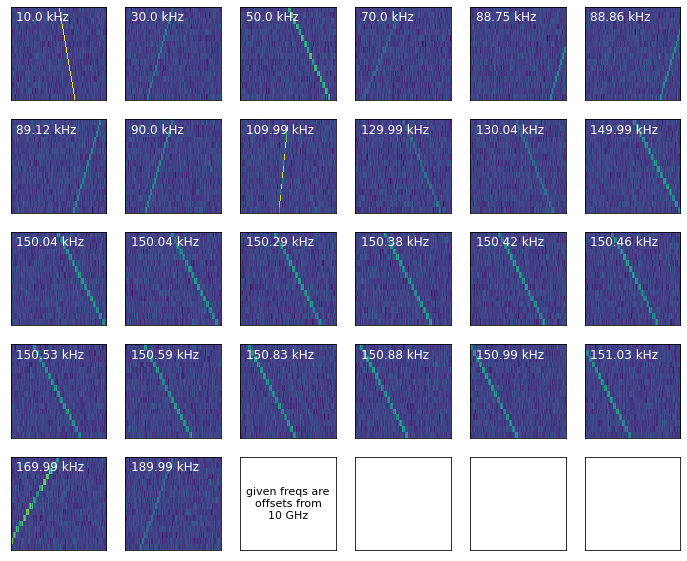

In [7]:
fig, axs = plt.subplots(5, 6, figsize=(12, 10))
# bw = 0.001
for i in range(5):
    for j in range(6):
        k = 6*i+j
        if k < 26:
            f = ff[k]
            fb = bl.Waterfall(h5, f_start=f-bw/2, f_stop=f+bw/2)
            data = np.squeeze(fb.data)
            axs[i][j].imshow(np.log10(data), interpolation='None', aspect='auto', vmin=np.log10(np.min(mins)), vmax=np.log10(np.max(maxes)))
            axs[i][j].text(0.06, 0.85, f'{round((f-10000)*1000, 2)} kHz', size=12, color='white', horizontalalignment='left', transform=axs[i][j].transAxes)
        elif k == 26:
            axs[i][j].text(0.5, 0.5, f'given freqs are\noffsets from\n10 GHz', size=11, color='black', horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
plt.savefig('/datax/scratch/benjb/bliss_voyager_test/injections/hit_plot.pdf', bbox_inches='tight')
plt.show()

1
2
3
4
5
6
7
8
9
(31, 9)


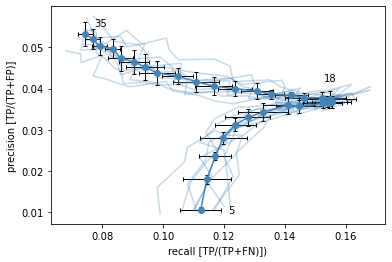

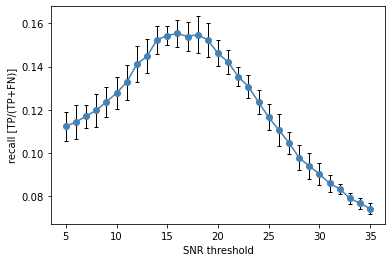

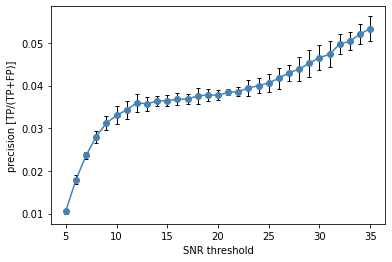

In [ ]:
sp_arr = []
sr_arr = []

for n in range(9):
    m = n+1
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injections_{m}*.dat')
    print(m)

    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []

    for k in range(len(dats)):

        dat = dats[k]

        snr = float(dat[89:-4])
        #print(snr)
        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf
            if np.min(np.abs(pdiffvec))*1000 < 0.1: # permit accuracy to within 0.1 kHz
                tp += 1
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        #print(f'TP: {tp}')
        #print(f'FP: {fp}')
        #print(f'FN: {fn}')

        #print(f'precision: {tp/(tp+fp)}')
        #print(f'recall: {tp/(tp+fn)}')
        precisions.append(tp/(tp+fp))
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    plt.plot(sr, sp, color='steelblue', alpha=0.3)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

plt.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='o', color='steelblue',
             ecolor='k', capsize=2, elinewidth=1)
plt.xlabel('recall [TP/(TP+FN)])')
plt.ylabel('precision [TP/(TP+FP)]')

best_snr = np.argmin(distvec) + 5
plt.text(sr_avgvec[np.argmin(distvec)], sp_avgvec[np.argmin(distvec)]+0.005, str(best_snr), ha='center', va='center')
plt.text(sr_avgvec[0]+0.01, sp_avgvec[0], 5, ha='center', va='center')
plt.text(sr_avgvec[-1]+0.005, sp_avgvec[-1]+0.0025, 35, ha='center', va='center')
#plt.xlim(0,1)
#plt.ylim(0,1)
#plt.savefig('/datax/scratch/benjb/bliss_voyager_test/injections/bliss_PR_curve_9_realizations_SNRs_10_1000.pdf', bbox_inches='tight')
plt.show()

plt.errorbar(np.sort(snrs), sr_avgvec, sr_errvec, c='steelblue', marker='o', ecolor='k', capsize=2, elinewidth=1, label='recall')
plt.errorbar(np.sort(snrs), sp_avgvec, sp_errvec, c='firebrick', marker='o', ecolor='k', capsize=2, elinewidth=1, label='precision')
plt.xlabel('SNR threshold')
plt.ylabel('fraction (precision or recall)')
plt.show()

0
1
(31, 2)


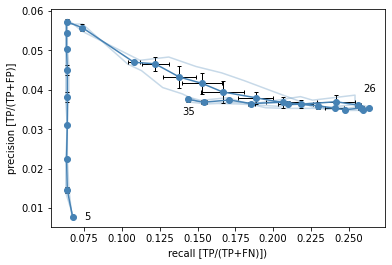

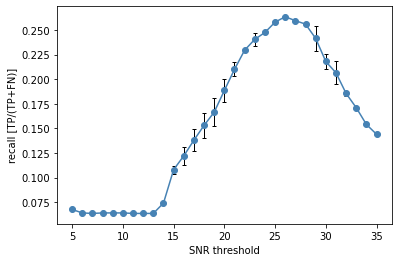

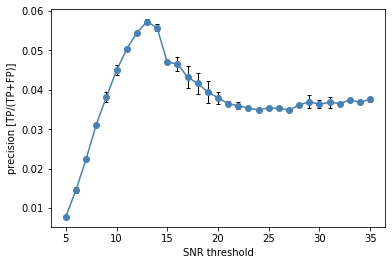

In [52]:
sp_arr = []
sr_arr = []

for n in range(2):
    m = n
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_injections/synthetic_data_2000_injections_{m}*.dat')
    print(m)

    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []

    for k in range(len(dats)):

        dat = dats[k]

        snr = float(dat[109:-4])
        #print(snr)
        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf
            if np.min(np.abs(pdiffvec))*1000 < 0.1: # permit accuracy to within 0.1 kHz
                tp += 1
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        #print(f'TP: {tp}')
        #print(f'FP: {fp}')
        #print(f'FN: {fn}')

        #print(f'precision: {tp/(tp+fp)}')
        #print(f'recall: {tp/(tp+fn)}')
        precisions.append(tp/(tp+fp))
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    plt.plot(sr, sp, color='steelblue', alpha=0.3)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

plt.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='o', color='steelblue',
             ecolor='k', capsize=2, elinewidth=1)
plt.xlabel('recall [TP/(TP+FN)])')
plt.ylabel('precision [TP/(TP+FP)]')

best_snr = np.argmin(distvec) + 5
plt.text(sr_avgvec[np.argmin(distvec)], sp_avgvec[np.argmin(distvec)]+0.005, str(best_snr), ha='center', va='center')
plt.text(sr_avgvec[0]+0.01, sp_avgvec[0], 5, ha='center', va='center')
plt.text(sr_avgvec[-1], sp_avgvec[-1]-0.003, 35, ha='center', va='center')
#plt.xlim(0,1)
#plt.ylim(0,1)
#plt.savefig('/datax/scratch/benjb/bliss_voyager_test/injections/bliss_PR_curve_10_realizations_SNRs_1000.pdf', bbox_inches='tight')
plt.show()

plt.errorbar(np.sort(snrs), sr_avgvec, sr_errvec, c='steelblue', marker='o', ecolor='k', capsize=2, elinewidth=1)
plt.xlabel('SNR threshold')
plt.ylabel('recall [TP/(TP+FN)]')
plt.show()

plt.errorbar(np.sort(snrs), sp_avgvec, sp_errvec, c='steelblue', marker='o', ecolor='k', capsize=2, elinewidth=1)
plt.xlabel('SNR threshold')
plt.ylabel('precision [TP/(TP+FP)]')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


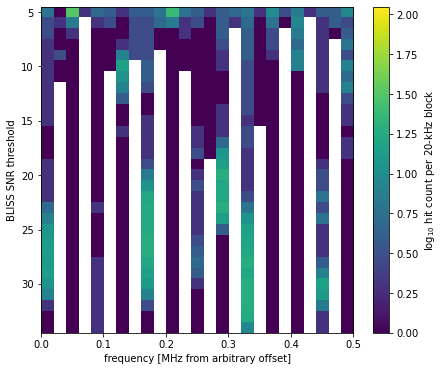

In [50]:
hist_arr = []
fig, ax = plt.subplots(figsize=(7,6))
for j in np.arange(start=5, stop=35):
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injections_*.0000_{j}.dat')
    for i in range(len(dats)):
        fvec = []
        dat = dats[i]
        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        fvec.append(ff)
    fvec = np.concatenate(fvec)
    hist,_ = np.histogram(ff, bins=2000, range=(10000, 10040))
    hist_arr.append(hist)
#hist_arr.append(np.zeros_like(hist_arr[0])+1000)
hist_arr = np.array(hist_arr)
plt.imshow(np.log10(hist_arr), aspect='auto', 
           #cmap='binary', 
           interpolation='None', extent=(0, 40, 34.5, 4.5))
plt.xlabel('frequency [MHz from arbitrary offset]')
plt.ylabel('BLISS SNR threshold')
plt.colorbar(label=r'log$_{10}$ hit count per 20-kHz block')
plt.xlim(0, 0.5)
plt.show()


In [19]:
print(np.min(ff))
print(np.max(ff))

10000.000039
10039.998392
